<h1><center>Neural Network for classification task</center></h1>
<p><center>Padideh Nouri</center></p>
<p><center>Implementation from scratch + Examples of use with their plots</center></p>

<br>

# Ex 1:
Neural network with:

- 2 hidden layers, of size 512 and 256 respectively 
- dataset: SVHN dataset
- 30 epochs
- learning rate 0.03
- batch size  100
- RELU activation function


Estimated time: 00:06:33


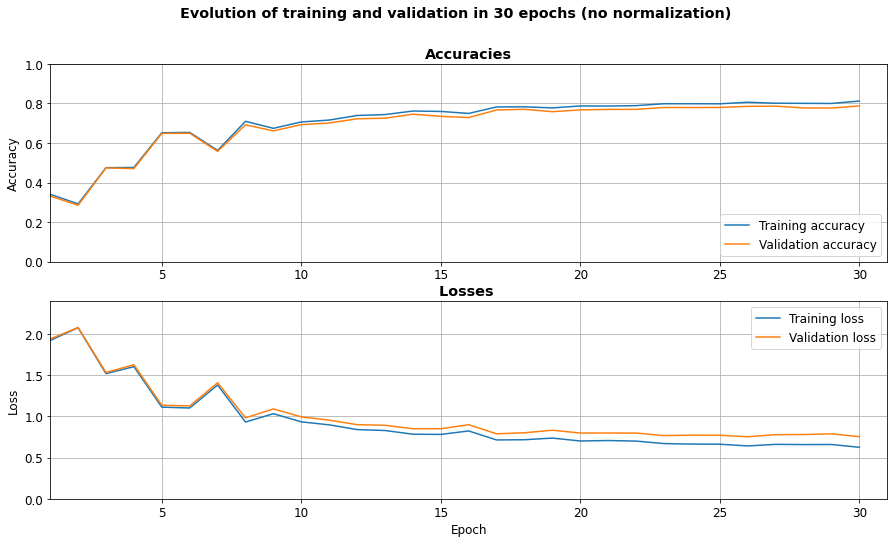

In [28]:
t_0 = time.time()
nn = NN(hidden_dims=(512, 256))
train_log = nn.train_loop(30)
t_1 = time.time()
delta = t_1-t_0
print('Estimated time:',time.strftime('%H:%M:%S', time.gmtime(delta)))
make_plot('no normalization')

# Ex 2:

- Effects of normalization.

Estimated time: 00:06:34


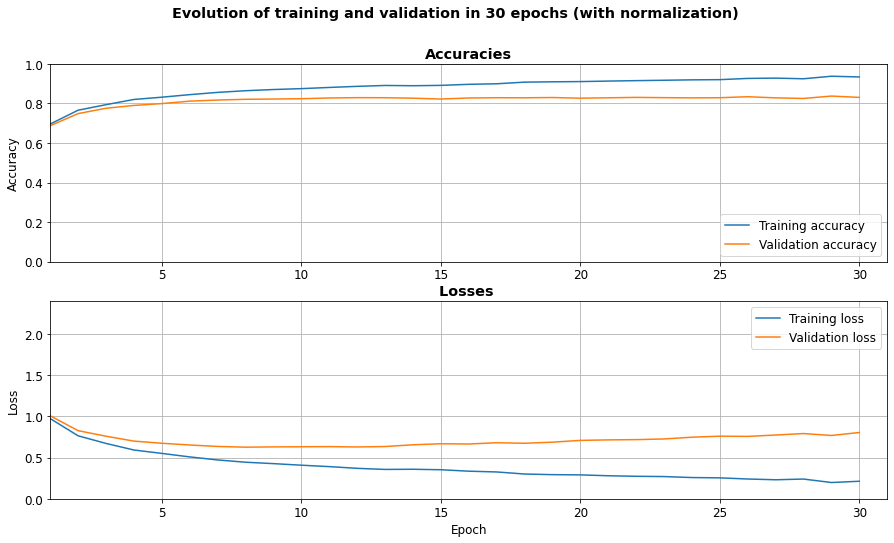

In [31]:
t_0 = time.time()
nn_normal = NN(hidden_dims=(512, 256), normalization=True)
train_log = nn_normal.train_loop(30)
t_1 = time.time()
delta = t_1-t_0
print('Estimated time:',time.strftime('%H:%M:%S', time.gmtime(delta)))
make_plot('with normalization')

# ex 3:
- Effects of depth and width of the NN 

Estimated time: 00:09:35


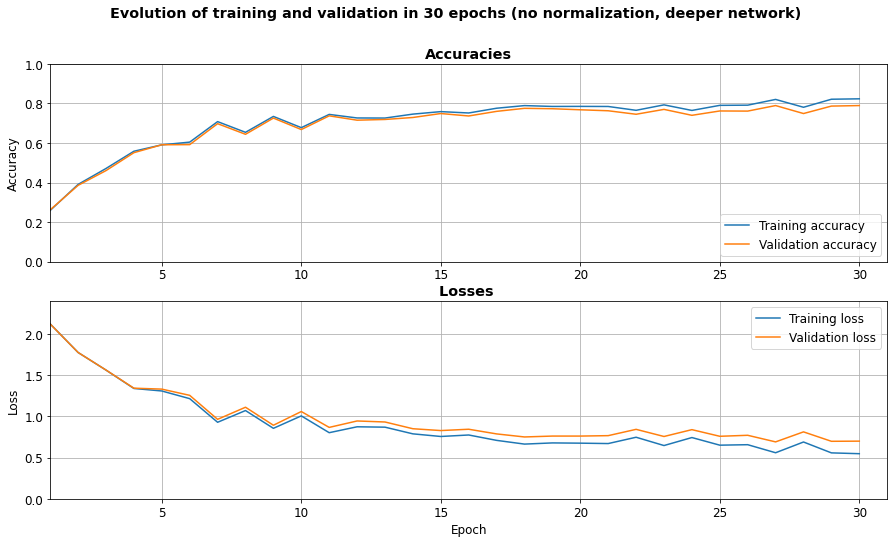

In [57]:
t_0 = time.time()
nn = NN(hidden_dims=(512, 120, 120, 120, 120, 120, 120))
train_log = nn.train_loop(30)
t_1 = time.time()
delta = t_1-t_0
print('Estimated time:',time.strftime('%H:%M:%S', time.gmtime(delta)))
make_plot('no normalization, deeper network')

# Codes:

In [58]:
import pickle
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [55]:
class NN(object):
    def __init__(self,
                 hidden_dims=(512, 256),
                 datapath='svhn.pkl',
                 n_classes=10,
                 epsilon=1e-6,
                 lr=0.03,
                 batch_size=100,
                 seed=0,
                 activation="relu",
                 init_method="glorot",
                 normalization=False
                 ):

        self.hidden_dims = hidden_dims
        self.n_hidden = len(hidden_dims)
        self.datapath = datapath
        self.n_classes = n_classes
        self.lr = lr
        self.batch_size = batch_size
        self.init_method = init_method
        self.seed = seed
        self.activation_str = activation
        self.epsilon = epsilon

        self.train_logs = {'train_accuracy': [], 'validation_accuracy': [], \
                           'train_loss': [], 'validation_loss': []}

        if datapath is not None:
            u = pickle._Unpickler(open(datapath, 'rb'))
            u.encoding = 'latin1'
            self.train, self.valid, self.test = u.load()
            if normalization:
                self.normalize()
        else:
            self.train, self.valid, self.test = None, None, None

    def initialize_weights(self, dims):
        if self.seed is not None:
            np.random.seed(self.seed)
        self.weights = {}
        # self.weights is a dictionnary with keys W1, b1, W2, b2, ..., Wm, Bm 
        # where m - 1 is the number of hidden layers
        all_dims = [dims[0]] + list(self.hidden_dims) + [dims[1]]
        for layer_n in range(1, self.n_hidden + 2):
            s = np.sqrt(6 / (all_dims[layer_n-1] + all_dims[layer_n]))
            self.weights[f"W{layer_n}"] = np.random.uniform(-s,s,(all_dims[layer_n-1],\
                                                                  all_dims[layer_n]))
            self.weights[f"b{layer_n}"] = np.zeros((1, all_dims[layer_n]))

    def relu(self, x, grad=False):
        x=np.array(x)
        if grad:
            x[x > 0] = 1
            x[x <= 0] = 0
            return x
        else:
            return np.maximum(0,x)

    def sigmoid(self, x, grad=False):
        x=np.array(x)
        if grad:
            s = self.sigmoid(x, grad=False)
            return s * (1- s)
        else:
            return 1.0 / (1 + np.exp(-x))

    def tanh(self, x, grad=False):
        x=np.array(x)
        if grad:
            tmp = self.tanh(x, grad=False)
            return 1 - tmp * tmp
        else:
            a = np.exp(x)
            b = np.exp(-x)
            return (a-b)/(a+b)

    def leakyrelu(self, x, grad=False):
        x=np.array(x)
        alpha = 0.01
        if grad:
            dx = np.ones(x.shape)
            dx[x <= 0] = alpha
            return dx
        else:
            a = np.maximum(0, x)
            b = alpha * np.minimum(0, x)
            c=a+b
            return c

    def activation(self, x, grad=False):
        x= np.array(x)
        if self.activation_str == "relu":
            return self.relu(x, grad=grad)
        elif self.activation_str == "sigmoid":
            return self.sigmoid(x, grad=grad)
        elif self.activation_str == "tanh":
            return self.tanh(x, grad=grad)
        elif self.activation_str == "leakyrelu":
            return self.leakyrelu(x, grad=grad)
        else:
            raise Exception("invalid")

    def softmax(self, x):
        y = x - np.max(x, axis=-1, keepdims=True)
        one_y = np.exp(y)
        all_y = np.sum(one_y, axis=-1, keepdims=True)
        value = one_y / all_y
        return value

    def forward(self, x):
        cache = {"Z0": x}
        for layer_n in range(1, self.n_hidden + 1):
            
            cache[f"A{layer_n}"] = self.weights[f"b{layer_n}"] + \
            np.matmul(cache[f"Z{layer_n-1}"],self.weights[f"W{layer_n}"])
            
            cache[f"Z{layer_n}"] = self.activation(cache[f"A{layer_n}"], grad=False)
            
        cache[f"A{self.n_hidden + 1}"] = self.weights[f"b{self.n_hidden + 1}"] + \
        np.matmul(cache[f"Z{self.n_hidden }"], self.weights[f"W{self.n_hidden + 1}"])
        
        cache[f"Z{self.n_hidden + 1}"] = self.softmax(cache[f"A{self.n_hidden + 1}"])
        
        return cache

    def backward(self, cache, labels):
        output = cache[f"Z{self.n_hidden + 1}"]
        grads = {}
        grads[f"dA{self.n_hidden+1}"] = output - labels

        for layer_n in range(self.n_hidden+1 , 1, -1):
            grads[f"dW{layer_n}"] = np.dot(cache[f"Z{layer_n - 1}"].T, 
                                           grads[f"dA{layer_n}"]) / self.batch_size
            
            grads[f"db{layer_n}"] = np.sum(grads[f"dA{layer_n}"], axis=0, 
                                           keepdims=True) / self.batch_size
            
            grads[f"dZ{layer_n - 1}"] = np.dot(grads[f"dA{layer_n}"],  
                                               self.weights[f"W{layer_n}"].T)
            
            grads[f"dA{layer_n - 1}"] = grads[f"dZ{layer_n - 1}"] * \
            self.activation(cache[f"A{layer_n - 1}"],grad=True)

        grads[f"dW{1}"] = np.dot(cache[f"Z{0}"].T, grads[f"dA{1}"]) / self.batch_size
        grads[f"db{1}"] = np.sum(grads[f"dA{1}"], axis=0, keepdims=True) / self.batch_size
        return grads

    def update(self, grads):
        for layer_n in range(1, self.n_hidden + 2):
            self.weights[f"W{layer_n}"] -= self.lr * grads[f"dW{layer_n}"]
            self.weights[f"b{layer_n}"] -= self.lr * grads[f"db{layer_n}"]

    def one_hot(self, y):
        y_one_hot = np.zeros((len(y),self.n_classes))
        for i in range(len(y)):
            y_one_hot[i, y[i]] = 1.0
        return y_one_hot

    def loss(self, prediction, labels):
        prediction[np.where(prediction < self.epsilon)] = self.epsilon
        prediction[np.where(prediction > 1 - self.epsilon)] = 1 - self.epsilon
        tmp_L = -np.sum(labels * np.log(prediction))
        return tmp_L / labels.shape[0]

    def compute_loss_and_accuracy(self, X, y):
        one_y = self.one_hot(y)
        cache = self.forward(X)
        predictions = np.argmax(cache[f"Z{self.n_hidden + 1}"], axis=1)
        accuracy = np.mean(y == predictions)
        loss = self.loss(cache[f"Z{self.n_hidden + 1}"], one_y)
        return loss, accuracy, predictions

    def train_loop(self, n_epochs):
        X_train, y_train = self.train
        y_onehot = self.one_hot(y_train)
        dims = [X_train.shape[1], y_onehot.shape[1]]
        self.initialize_weights(dims)
        n_batches = int(np.ceil(X_train.shape[0] / self.batch_size))

        for epoch in range(n_epochs):
            for batch in range(n_batches):
                minibatchX = X_train[self.batch_size * batch:self.batch_size *\
                                     (batch + 1), :]
                minibatchY = y_onehot[self.batch_size * batch:self.batch_size *\
                                      (batch + 1), :]
                cache = self.forward(minibatchX)
                grads = self.backward(cache, minibatchY)
                self.update(grads)
            X_train, y_train = self.train
            train_loss, train_accuracy, _ = self.compute_loss_and_accuracy(X_train, 
                                                                           y_train)
            X_valid, y_valid = self.valid
            valid_loss, valid_accuracy, _ = self.compute_loss_and_accuracy(X_valid,
                                                                           y_valid)

            self.train_logs['train_accuracy'].append(train_accuracy)
            self.train_logs['validation_accuracy'].append(valid_accuracy)
            self.train_logs['train_loss'].append(train_loss)
            self.train_logs['validation_loss'].append(valid_loss)
        return self.train_logs

    def evaluate(self):
        X_test, y_test = self.test
        test_loss, test_accuracy, _ = self.compute_loss_and_accuracy(X_test, y_test)
        return test_loss, test_accuracy

    def normalize(self):
        # compute mean and std along the first axis
        X_train, y_train = self.train
        #mean = np.mean(X_train, axis=0, keepdims=True)
        #std = np.std(X_train, axis=0, keepdims=True)
        mean = np.mean(X_train)
        std = np.std(X_train)
        
        X_train = (X_train - mean) / std
        self.train = X_train, y_train

        X_valid, y_valid = self.valid
        X_valid = (X_valid - mean) / std
        self.valid = X_valid, y_valid

        X_test, y_test = self.test
        X_test = (X_test - mean) / std
        self.test = X_test, y_test

In [56]:
# code for plots
def make_plot(x):
    plt.rcParams['font.size'] = 12
    fig, ax = plt.subplots(2,1, figsize=(15,8))
    ax[0].plot(range(1,31), train_log['train_accuracy'] , label= 'Training accuracy')
    ax[0].plot(range(1,31), train_log['validation_accuracy'],label='Validation accuracy')
    ax[1].plot(range(1,31), train_log['train_loss'] , label= 'Training loss')
    ax[1].plot(range(1,31), train_log['validation_loss'] , label= 'Validation loss')
    ax[0].set_ylim(0, 1)
    ax[1].set_ylim(0, 2.4)
    ax[0].set_xlim(1, 31)
    ax[1].set_xlim(1, 31)
    ax[0].legend(loc='lower right')
    ax[1].legend(loc='upper right')
    ax[0].grid()
    ax[1].grid()
    ax[0].set_title('Accuracies',fontweight='bold')
    ax[0].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_title('Losses ',fontweight='bold')
    ax[1].set_ylabel('Loss')
    fig.suptitle('Evolution of training and validation in 30 epochs ({})'
                 .format(x),fontweight='bold')
    plt.show();